PPO(Proximal Policy Optimization): The actors use this algorithm to make a decision(Action) to effect their environment.


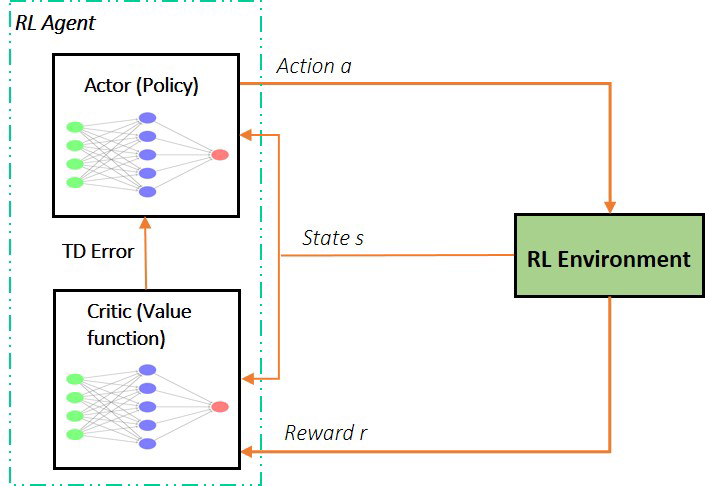

In [ ]:
import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical

################################## set device ##################################
print("============================================================================================")
# set device to cpu or cuda
device = torch.device('cpu')
if(torch.cuda.is_available()): 
    device = torch.device('cuda:0') 
    torch.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))
else:
    print("Device set to : cpu")
print("============================================================================================")


################################## PPO Policy ##################################
class RolloutBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.state_values = []
        self.is_terminals = []
    
    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.state_values[:]
        del self.is_terminals[:]


class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, has_continuous_action_space, action_std_init):
        super(ActorCritic, self).__init__()

        self.has_continuous_action_space = has_continuous_action_space
        
        if has_continuous_action_space:
            self.action_dim = action_dim
            self.action_var = torch.full((action_dim,), action_std_init * action_std_init).to(device)
        # actor
        if has_continuous_action_space :
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, 64),
                            nn.Tanh(),
                            nn.Linear(64, 64),
                            nn.Tanh(),
                            nn.Linear(64, action_dim),
                            nn.Tanh()
                        )
        else:
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, 64),
                            nn.Tanh(),
                            nn.Linear(64, 64),
                            nn.Tanh(),
                            nn.Linear(64, action_dim),
                            nn.Softmax(dim=-1)
                        )
        # critic
        self.critic = nn.Sequential(
                        nn.Linear(state_dim, 64),
                        nn.Tanh(),
                        nn.Linear(64, 64),
                        nn.Tanh(),
                        nn.Linear(64, 1)
                    )
        
    def set_action_std(self, new_action_std):
        if self.has_continuous_action_space:
            self.action_var = torch.full((self.action_dim,), new_action_std * new_action_std).to(device)
        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling ActorCritic::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")

    def forward(self):
        raise NotImplementedError
    
    def act(self, state):

        if self.has_continuous_action_space:
            action_mean = self.actor(state)
            cov_mat = torch.diag(self.action_var).unsqueeze(dim=0)
            dist = MultivariateNormal(action_mean, cov_mat)
        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)

        action = dist.sample()
        action_logprob = dist.log_prob(action)
        state_val = self.critic(state)

        return action.detach(), action_logprob.detach(), state_val.detach()
    
    def evaluate(self, state, action):

        if self.has_continuous_action_space:
            action_mean = self.actor(state)
            
            action_var = self.action_var.expand_as(action_mean)
            cov_mat = torch.diag_embed(action_var).to(device)
            dist = MultivariateNormal(action_mean, cov_mat)
            
            # For Single Action Environments.
            if self.action_dim == 1:
                action = action.reshape(-1, self.action_dim)
        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_values = self.critic(state)
        
        return action_logprobs, state_values, dist_entropy


class PPO:
    def __init__(self, state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std_init=0.6):

        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:
            self.action_std = action_std_init

        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        
        self.buffer = RolloutBuffer()

        self.policy = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.optimizer = torch.optim.Adam([
                        {'params': self.policy.actor.parameters(), 'lr': lr_actor},
                        {'params': self.policy.critic.parameters(), 'lr': lr_critic}
                    ])

        self.policy_old = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.MseLoss = nn.MSELoss()

    def set_action_std(self, new_action_std):
        if self.has_continuous_action_space:
            self.action_std = new_action_std
            self.policy.set_action_std(new_action_std)
            self.policy_old.set_action_std(new_action_std)
        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling PPO::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")

    def decay_action_std(self, action_std_decay_rate, min_action_std):
        print("--------------------------------------------------------------------------------------------")
        if self.has_continuous_action_space:
            self.action_std = self.action_std - action_std_decay_rate
            self.action_std = round(self.action_std, 4)
            if (self.action_std <= min_action_std):
                self.action_std = min_action_std
                print("setting actor output action_std to min_action_std : ", self.action_std)
            else:
                print("setting actor output action_std to : ", self.action_std)
            self.set_action_std(self.action_std)

        else:
            print("WARNING : Calling PPO::decay_action_std() on discrete action space policy")
        print("--------------------------------------------------------------------------------------------")

    def select_action(self, state):

        if self.has_continuous_action_space:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                action, action_logprob, state_val = self.policy_old.act(state)

            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)
            self.buffer.state_values.append(state_val)

            return action.detach().cpu().numpy().flatten()
        else:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                action, action_logprob, state_val = self.policy_old.act(state)
            
            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)
            self.buffer.state_values.append(state_val)

            return action.item()

    def update(self):
        # Monte Carlo estimate of returns
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.buffer.rewards), reversed(self.buffer.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
            
        # Normalizing the rewards
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        # convert list to tensor
        old_states = torch.squeeze(torch.stack(self.buffer.states, dim=0)).detach().to(device)
        old_actions = torch.squeeze(torch.stack(self.buffer.actions, dim=0)).detach().to(device)
        old_logprobs = torch.squeeze(torch.stack(self.buffer.logprobs, dim=0)).detach().to(device)
        old_state_values = torch.squeeze(torch.stack(self.buffer.state_values, dim=0)).detach().to(device)

        # calculate advantages
        advantages = rewards.detach() - old_state_values.detach()

        # Optimize policy for K epochs
        for _ in range(self.K_epochs):

            # Evaluating old actions and values
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)

            # match state_values tensor dimensions with rewards tensor
            state_values = torch.squeeze(state_values)
            
            # Finding the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss  
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages

            # final loss of clipped objective PPO
            loss = -torch.min(surr1, surr2) + 0.5 * self.MseLoss(state_values, rewards) - 0.01 * dist_entropy
            
            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
            
        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())

        # clear buffer
        self.buffer.clear()
    
    def save(self, checkpoint_path):
        torch.save(self.policy_old.state_dict(), checkpoint_path)
   
    def load(self, checkpoint_path):
        self.policy_old.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        self.policy.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))


ENVIRONMENT: We define the environment states and the different parameters like the duration of each state, the number of ev's a company has, the carbon emmited in that state, their revenue, etc.

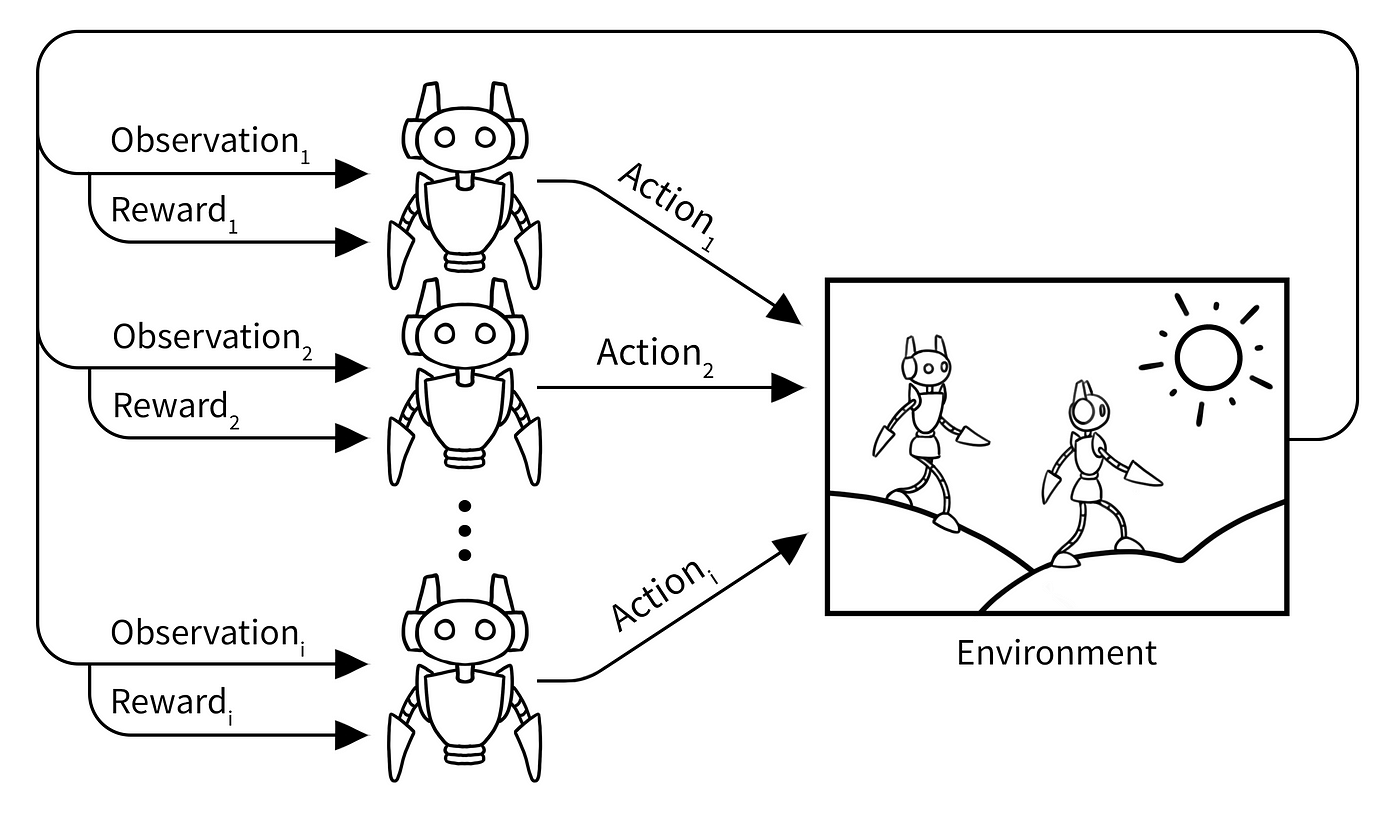

In [ ]:
import random
import numpy as np
import time

class CarbonTaxEnvironment:
    def __init__(self, max_days, initial_revenue, initial_expenses, initial_money_in_bank, initial_max_car, initial_ev, initial_petrol_car, initial_power_consumption, initial_power_generation, initial_solar_panel, initial_electricity_price, max_electricity, initial_carbon_tax):
        self.num_day = max_days  # 5 years
        self.current_day = 0
        self.observation_space_dim = 10  # Adjust if needed for your state
        self.action_space_dim = 3  # 3 possible actions

        self.revenue = initial_revenue
        self.initial_expenses = initial_expenses
        self.initial_money_in_bank = initial_money_in_bank
        self.max_car = initial_max_car
        self.initial_ev = initial_ev
        self.initial_petrol_car = initial_petrol_car
        self.initial_power_consumption = initial_power_consumption
        self.initial_power_generation = initial_power_generation
        self.initial_solar_panel = initial_solar_panel
        self.electricity_price = initial_electricity_price
        self.carbon_tax = initial_carbon_tax
        self.max_electricity = max_electricity
        self.initial_state = self._initialize_state()
    def _initialize_state(self):
        # Define the starting values for:
        # All information are for day
        # unit are in dollars, kwh, km, kg
        self.expenses = self.initial_expenses
        self.money_in_bank = self.initial_money_in_bank

        self.ev = self.initial_ev
        self.petrol_car = self.initial_petrol_car
        self.car_mile = 200
        self.pertrol_per_km = 0.06
        self.car_carbon_per_km = 0.2
        self.ev_per_km = 0.147

        self.power_consumption = self.initial_power_consumption
        self.carbon_per_kwh_generated = 0.4057
        self.power_generation = self.initial_power_generation
        self.solar_panel = self.initial_solar_panel

        _,_,_,_,_,self.init_carbon_emitted = self.calculate_expenses()

        state = [self.revenue, self.expenses, self.money_in_bank, self.ev, self.petrol_car,
                 self.power_consumption, self.power_generation, self.solar_panel, self.electricity_price, self.carbon_tax]

        return state
    
    def calculate_expenses(self):
        power_by_ev = self.ev * self.ev_per_km * self.car_mile
        power_from_grid = self.power_consumption + power_by_ev - self.power_generation
        carbon_from_power = power_from_grid * self.carbon_per_kwh_generated
        cost_of_electricity = power_from_grid * self.electricity_price
        petrol_cost = self.petrol_car * self.car_mile * self.pertrol_per_km
        carbon_emitted = self.petrol_car * self.car_mile * self.car_carbon_per_km + carbon_from_power
        return power_by_ev, power_from_grid, carbon_from_power, cost_of_electricity, petrol_cost, carbon_emitted

    def step(self, action):
        # 1. Apply the effect of current carbon tax rate and the 'action'
        reward = 0
        bankrupcy = False

        if action == 0:  # Buy EV
            if self.ev < self.max_car:
                self.ev += 1
                self.petrol_car = max(0, self.petrol_car - 1)
                self.money_in_bank -= 30000
            else:
                reward = -50
        elif action == 1:  # Buy solar panel
            if self.power_generation <= self.max_electricity:
                self.solar_panel += 1
                self.money_in_bank -= 900
                self.power_generation += 2
            else:
                reward = -10
        elif action == 2:  # Do nothing
            reward -= 1


        # 2. Simulate company behaviors (randomness might be involved)
        # generate a number based on normal distribution
        # self.revenue = int(self.revenue * (1 + random.gauss(0, 0.1))) # 10% fluctuation
        # if self.revenue <= 0:
        #     self.revenue = 1
        # self.car_mile = int(self.car_mile * (1 + random.gauss(0, 0.2))) # 20% fluctuation
        # self.power_consumption = int(self.power_consumption * (1 + random.gauss(0, 0.2))) # 20% fluctuation

        # 3. Update your state variables:
        power_by_ev, power_from_grid, carbon_from_power, cost_of_electricity, petrol_cost, carbon_emitted = self.calculate_expenses()

        if power_from_grid < 0:
            surplus_power = -power_from_grid
        else:
            surplus_power = 0

        if carbon_emitted < 0:
            carbon_surplus = -carbon_emitted
        else:
            carbon_surplus = 0
            
        carbon_tax_cost = carbon_emitted * self.carbon_tax

        self.expenses = carbon_tax_cost + cost_of_electricity + petrol_cost + self.initial_expenses  # Simplifying other expenses

        self.money_in_bank += self.revenue - self.expenses

        # reward = self.money_in_bank * 0.00000001 - carbon_emitted * 0.0001

        reward = reward + ((self.money_in_bank - self.initial_money_in_bank) / self.initial_money_in_bank * 10 - (carbon_emitted - self.init_carbon_emitted) / self.init_carbon_emitted * 10)
        # print(f'reward: {reward}')

        # reward = reward / self.revenue  * 10
        money_in_bank = self.money_in_bank

        if self.money_in_bank < 0:
            done = True
            bankrupcy = True
            reward = -100
            self.reset()
        elif self.current_day >= self.num_day:
            done = True
            self.reset()
        else:
            done = False

        # Normalize to -3 to 3 range
        # reward = (reward - 1e7) / 1e7
        # print(f'Current Day: {self.current_day}, Action: {action} Reward: {reward}, Money in Bank: {self.money_in_bank}, EV: {self.ev}, Solar Panel: {self.solar_panel}, carbon emitted: {carbon_emitted}, carbon surplus: {carbon_surplus}, carbon tax cost: {carbon_tax_cost}, petrol cost: {petrol_cost}, bankrupcy: {bankrupcy}')
        # time.sleep(1)

        # 5-6. Check for end of episode and get new state
        self.current_day += 1
        new_state = self._get_current_state()  # Get the updated state

        data = [carbon_emitted, surplus_power, carbon_tax_cost, petrol_cost, carbon_surplus, bankrupcy, money_in_bank]
        visualization  = [self.ev, self.petrol_car, self.solar_panel, self.power_generation, self.power_consumption, self.electricity_price, self.carbon_tax, self.revenue, self.expenses, self.money_in_bank, self.current_day, self.max_car, self.max_electricity]

        return new_state, reward, done, data, visualization

    def reset(self):
        self.current_day = 0
        state = self._initialize_state()
        return state

    def _get_current_state(self):  # Helper to get the current state as an array
        return np.array([self.revenue, self.expenses, self.money_in_bank, self.ev, self.petrol_car,
                 self.power_consumption, self.power_generation, self.solar_panel,
                 self.electricity_price, self.carbon_tax])

    @property  # Add a property for observation_space
    def observation_space(self):
        return np.zeros(self.observation_space_dim)

    @property
    def action_space(self):
        return np.zeros(self.action_space_dim)


SIMULATOR: This is where we can actually run the model to see how different agents behave given the environment policies set by the user.

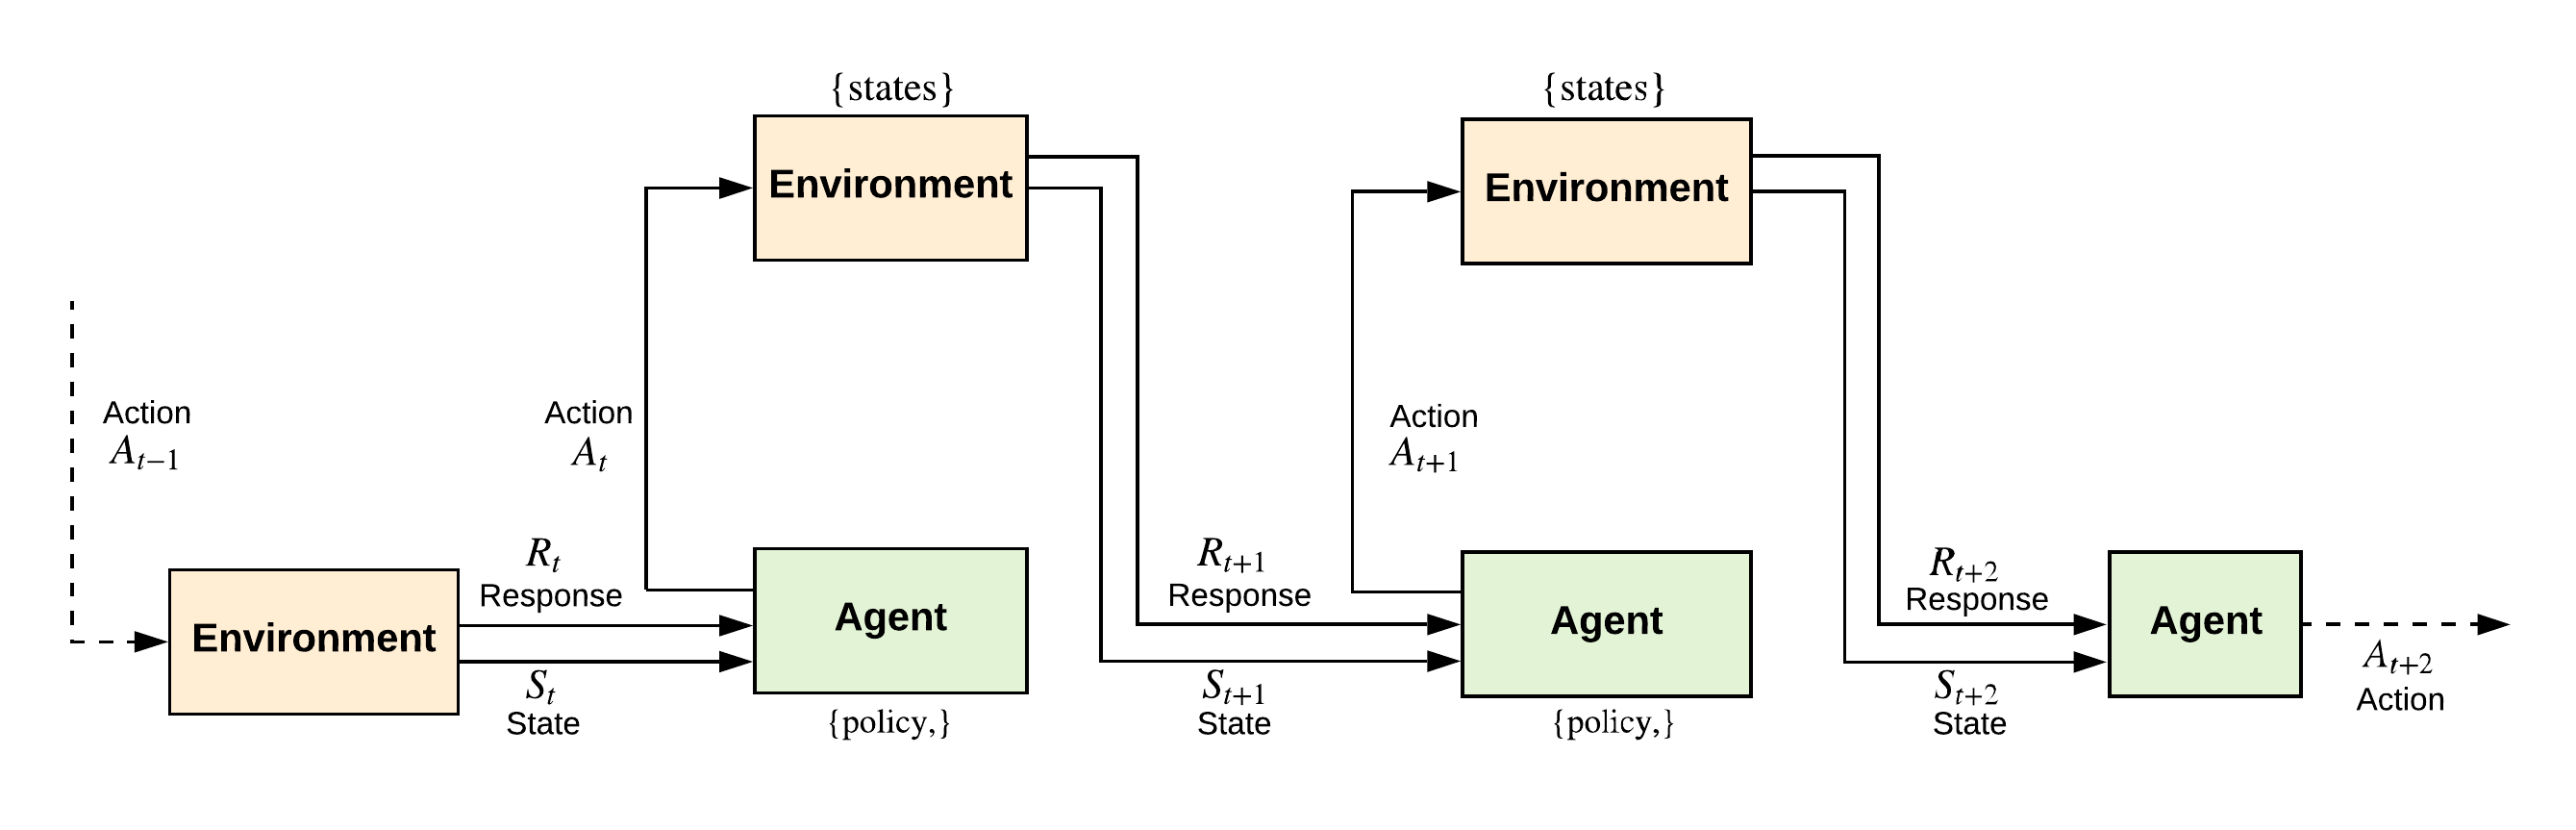

In [ ]:
import os
import glob
import time
from datetime import datetime

import torch
import numpy as np

from environment import CarbonTaxEnvironment

from PPO import PPO

# use tensorboard to plot the carbon emitted and bank
from torch.utils.tensorboard import SummaryWriter


class Trainer:
    def __init__(self, env_name, revenue, expenses, money_in_bank, max_car, ev, petrol_car, power_consumption, power_generation, solar_panel, max_electricity, electricity_price, carbon_tax):
        self.env_name = env_name
        self.revenue = revenue
        self.expenses = expenses
        self.money_in_bank = money_in_bank
        self.max_car = max_car
        self.ev = ev
        self.petrol_car = petrol_car
        self.power_consumption = power_consumption
        self.power_generation = power_generation
        self.solar_panel = solar_panel
        self.electricity_price = electricity_price
        self.max_electricity = max_electricity
        self.carbon_tax = carbon_tax

        self.summary_writer = SummaryWriter(f'tensorboard/{env_name}')

    ################################### Training ###################################
    def train(self):
        print("============================================================================================")

        ####### initialize environment hyperparameters ######
        env_name = self.env_name

        has_continuous_action_space = False  # continuous action space; else discrete

        max_ep_len = 5000                   # max timesteps in one episode
        max_training_timesteps = int(3e6)   # break training loop if timeteps > max_training_timesteps

        print_freq = max_ep_len * 1        # print avg reward in the interval (in num timesteps)
        log_freq = max_ep_len * 2           # log avg reward in the interval (in num timesteps)
        save_model_freq = int(1e5)          # save model frequency (in num timesteps)

        action_std = 0.6                    # starting std for action distribution (Multivariate Normal)
        action_std_decay_rate = 0.05        # linearly decay action_std (action_std = action_std - action_std_decay_rate)
        min_action_std = 0.1                # minimum action_std (stop decay after action_std <= min_action_std)
        action_std_decay_freq = int(2.5e5)  # action_std decay frequency (in num timesteps)
        #####################################################

        ## Note : print/log frequencies should be > than max_ep_len

        ################ PPO hyperparameters ################
        update_timestep = max_ep_len    # update policy every n timesteps
        K_epochs = 80                   # update policy for K epochs in one PPO update

        eps_clip = 0.2          # clip parameter for PPO
        gamma = 0.99            # discount factor

        lr_actor = 0.0003       # learning rate for actor network
        lr_critic = 0.001       # learning rate for critic network

        random_seed = 0         # set random seed if required (0 = no random seed)
        #####################################################

        print("training environment name : " + env_name)
        
        revenue = self.revenue
        expenses = self.expenses
        money_in_bank = self.money_in_bank

        max_car = self.max_car
        ev = self.ev
        petrol_car = self.petrol_car

        power_consumption = self.power_consumption
        power_generation = self.power_generation
        solar_panel = self.solar_panel
        max_electricity = self.max_electricity

        electricity_price = self.electricity_price
        carbon_tax = self.carbon_tax

        env = CarbonTaxEnvironment(max_ep_len, revenue, expenses, money_in_bank, max_car, ev, petrol_car, power_consumption, power_generation, solar_panel, electricity_price, max_electricity, carbon_tax)

        # state space dimension
        observation_space_array = env.observation_space  # Call the property
        state_dim = observation_space_array.shape[0] 

        action_dim = env.action_space_dim

        ###################### logging ######################

        # create a csv file for logging, with headers (sim_episode, sim_ev, sim_petrol_car, sim_solar_panel, sim_power_generation, sim_power_consumption, sim_electricity_price, sim_carbon_tax, sim_revenue, sim_expenses, sim_money_in_bank, sim_current_day, sim_max_car, sim_max_electricity)
        with open(f'simulation_log_{env_name}.csv', 'w') as f:
            f.write('sim_episode,sim_ev,sim_petrol_car,sim_solar_panel,sim_power_generation,sim_power_consumption,sim_electricity_price,sim_carbon_tax,sim_revenue,sim_expenses,sim_money_in_bank,sim_current_day,sim_max_car,sim_max_electricity,sim_surplus_power\n')

        #### log files for multiple runs are NOT overwritten
        log_dir = "PPO_logs"
        if not os.path.exists(log_dir):
            os.makedirs(log_dir)

        log_dir = log_dir + '/' + env_name + '/'
        if not os.path.exists(log_dir):
            os.makedirs(log_dir)

        #### get number of log files in log directory
        run_num = 0
        current_num_files = next(os.walk(log_dir))[2]
        run_num = len(current_num_files)

        #### create new log file for each run
        log_f_name = log_dir + '/PPO_' + env_name + "_log_" + str(run_num) + ".csv"

        print("current logging run number for " + env_name + " : ", run_num)
        print("logging at : " + log_f_name)
        #####################################################

        ################### checkpointing ###################
        run_num_pretrained = 0      #### change this to prevent overwriting weights in same env_name folder

        directory = "PPO_preTrained"
        if not os.path.exists(directory):
            os.makedirs(directory)

        directory = directory + '/' + env_name + '/'
        if not os.path.exists(directory):
            os.makedirs(directory)


        checkpoint_path = directory + "PPO_{}_{}_{}.pth".format(env_name, random_seed, run_num_pretrained)
        print("save checkpoint path : " + checkpoint_path)
        #####################################################


        ############# print all hyperparameters #############
        print("--------------------------------------------------------------------------------------------")
        print("max training timesteps : ", max_training_timesteps)
        print("max timesteps per episode : ", max_ep_len)
        print("model saving frequency : " + str(save_model_freq) + " timesteps")
        print("log frequency : " + str(log_freq) + " timesteps")
        print("printing average reward over episodes in last : " + str(print_freq) + " timesteps")
        print("--------------------------------------------------------------------------------------------")
        print("state space dimension : ", state_dim)
        print("action space dimension : ", action_dim)
        print("--------------------------------------------------------------------------------------------")
        if has_continuous_action_space:
            print("Initializing a continuous action space policy")
            print("--------------------------------------------------------------------------------------------")
            print("starting std of action distribution : ", action_std)
            print("decay rate of std of action distribution : ", action_std_decay_rate)
            print("minimum std of action distribution : ", min_action_std)
            print("decay frequency of std of action distribution : " + str(action_std_decay_freq) + " timesteps")
        else:
            print("Initializing a discrete action space policy")
        print("--------------------------------------------------------------------------------------------")
        print("PPO update frequency : " + str(update_timestep) + " timesteps")
        print("PPO K epochs : ", K_epochs)
        print("PPO epsilon clip : ", eps_clip)
        print("discount factor (gamma) : ", gamma)
        print("--------------------------------------------------------------------------------------------")
        print("optimizer learning rate actor : ", lr_actor)
        print("optimizer learning rate critic : ", lr_critic)
        if random_seed:
            print("--------------------------------------------------------------------------------------------")
            print("setting random seed to ", random_seed)
            torch.manual_seed(random_seed)
            env.seed(random_seed)
            np.random.seed(random_seed)
        #####################################################

        print("============================================================================================")

        ################# training procedure ################

        # initialize a PPO agent
        ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)

        # track total training time
        start_time = datetime.now().replace(microsecond=0)
        print("Started training at (GMT) : ", start_time)

        print("============================================================================================")

        # logging file
        log_f = open(log_f_name,"w+")
        log_f.write('episode,timestep,reward\n')

        # printing and logging variables
        print_running_reward = 0
        print_running_episodes = 0

        log_running_reward = 0
        log_running_episodes = 0

        time_step = 0
        i_episode = 0

        # training loop
        while time_step <= max_training_timesteps:

            state = env.reset()
            current_ep_reward = 0

            for t in range(1, max_ep_len+1):

                # select action with policy
                action = ppo_agent.select_action(state)
                state, reward, done, data, visualization = env.step(action)

                # unpack data
                carbon_emitted, surplus_power, carbon_tax_cost, petrol_cost, carbon_surplus, bankrupt, bank = data
                sim_ev, sim_petrol_car, sim_solar_panel, sim_power_generation, sim_power_consumption, sim_electricity_price, sim_carbon_tax, sim_revenue, sim_expenses, sim_money_in_bank, sim_current_day, sim_max_car, sim_max_electricity = visualization
                # saving reward and is_terminals
                ppo_agent.buffer.rewards.append(reward)
                ppo_agent.buffer.is_terminals.append(done)

                time_step +=1
                current_ep_reward += reward

                if done:
                    if bankrupt:
                        print(f'###################################Simulation failed due to bankrupt###################################')
                    print(f'Training Environment: {env_name}, Simulation Ended at day: {t}, Total amount in bank: {bank} carbon emitted: {carbon_emitted}, power surplus: {surplus_power}, carbon surplus: {carbon_surplus}, carbon tax cost: {carbon_tax_cost}')

                # update PPO agent
                if time_step % update_timestep == 0 or done:
                    ppo_agent.update()
                    

                # if continuous action space; then decay action std of ouput action distribution
                if has_continuous_action_space and time_step % action_std_decay_freq == 0:
                    ppo_agent.decay_action_std(action_std_decay_rate, min_action_std)

                # log in logging file
                if time_step % log_freq == 0:

                    # log average reward till last episode
                    log_avg_reward = log_running_reward / log_running_episodes
                    log_avg_reward = round(log_avg_reward, 4)

                    log_f.write('{},{},{}\n'.format(i_episode, time_step, log_avg_reward))
                    log_f.flush()

                    log_running_reward = 0
                    log_running_episodes = 0

                # save model weights
                if time_step % save_model_freq == 0:
                    print("--------------------------------------------------------------------------------------------")
                    print("saving model at : " + checkpoint_path)
                    ppo_agent.save(checkpoint_path)
                    print("model saved")
                    print("Elapsed Time  : ", datetime.now().replace(microsecond=0) - start_time)
                    print("--------------------------------------------------------------------------------------------")

                # break; if the episode is over
                if done:
                    break

            # log data into csv file
            with open(f'simulation_log_{env_name}.csv', 'a') as f:
                f.write(f'{i_episode},{sim_ev},{sim_petrol_car},{sim_solar_panel},{sim_power_generation},{sim_power_consumption},{sim_electricity_price},{sim_carbon_tax},{sim_revenue},{sim_expenses},{sim_money_in_bank},{sim_current_day},{sim_max_car},{sim_max_electricity},{surplus_power}\n')
            
            # carbon_emitted, surplus_power, carbon_tax_cost, petrol_cost, carbon_surplus, bankrupt, bank
            self.summary_writer.add_scalar('Carbon_Emitted', carbon_emitted, i_episode)
            self.summary_writer.add_scalar('Bank', bank, i_episode)
            self.summary_writer.add_scalar('Carbon_Tax_Cost', carbon_tax_cost, i_episode)
            self.summary_writer.add_scalar('Power_Surplus', surplus_power, i_episode)
            self.summary_writer.add_scalar('Carbon_Surplus', carbon_surplus, i_episode)
            self.summary_writer.add_scalar('Petrol_Cost', petrol_cost, i_episode)

            print_running_reward += current_ep_reward
            print_running_episodes += 1

            log_running_reward += current_ep_reward
            log_running_episodes += 1

            i_episode += 1

        log_f.close()
        env.close()

        # print total training time
        print("============================================================================================")
        end_time = datetime.now().replace(microsecond=0)
        print("Started training at (GMT) : ", start_time)
        print("Finished training at (GMT) : ", end_time)
        print("Total training time  : ", end_time - start_time)
        print("============================================================================================")

Simulation With Multiple Agents(Effect of params on different industries.) Different industries behave differently to these params. Each agent has their own heuristic to work towards. However, we have used the same PPO algo for all the agents

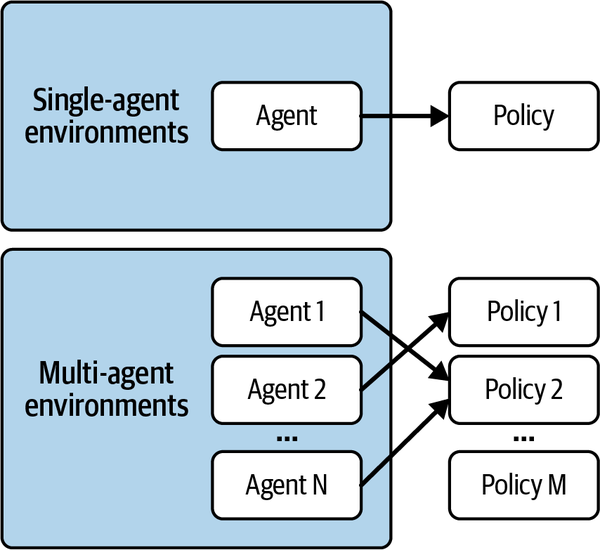

In [ ]:
from multiprocessing import Process
from simulator import Trainer  
import shutil

# multi_simulation.run(agrilculture_tax_rate, logistic_tax_rate, manufacturing_tax_rate, tech_tax_rate, electricity_price) 

def run_trainer(config):  # Function now takes a config dictionary
    trainer = Trainer(**config)  # Unpack the config dictionary 
    trainer.train()

def run(agrilculture_tax_rate, logistic_tax_rate, manufacturing_tax_rate, tech_tax_rate, electricity_price):
    shutil.rmtree('tensorboard', ignore_errors=True)
    
    set_electricity_price = electricity_price
    

    print("Running simulation with electricity price: ", set_electricity_price, " and carbon tax: ", agrilculture_tax_rate, 'for agriculture')
    print("Running simulation with electricity price: ", set_electricity_price, " and carbon tax: ", logistic_tax_rate, 'for logistic')
    print("Running simulation with electricity price: ", set_electricity_price, " and carbon tax: ", manufacturing_tax_rate, 'for manufacturing')
    print("Running simulation with electricity price: ", set_electricity_price, " and carbon tax: ", tech_tax_rate, 'for tech')
    print('===================================================================================================================')

    configurations = [
        {"env_name": "Logistic", "revenue": 200000, "expenses": 180000, "money_in_bank": int(2e7), 'max_car': 1000, 'ev': 5, 'petrol_car': 200, 
         'power_consumption': 2000, 'power_generation': 0, 'solar_panel': 0, 'max_electricity': 5000, 'electricity_price': set_electricity_price, 'carbon_tax': logistic_tax_rate},  # Config 1
        {"env_name": "Manufacturing", "revenue": 300000, "expenses": 295000, "money_in_bank": int(2e7), 'max_car': 100, 'ev': 0, 'petrol_car': 50, 
         'power_consumption': 5000, 'power_generation': 0, 'solar_panel': 0, 'max_electricity': 10000, 'electricity_price': set_electricity_price, 'carbon_tax': manufacturing_tax_rate},  # Config 2
        {"env_name": "Agriculture", "revenue": 30000, "expenses": 25000, "money_in_bank": int(2e7), 'max_car': 3000, 'ev': 10, 'petrol_car': 2, 
        'power_consumption': 3000, 'power_generation': 0, 'solar_panel': 0, 'max_electricity': 10000, 'electricity_price': set_electricity_price, 'carbon_tax': agrilculture_tax_rate},  # Config 3
        {"env_name": "Tech", "revenue": 500000, "expenses": 450000, "money_in_bank": int(2e7), 'max_car': 500, 'ev': 100, 'petrol_car': 0, 
        'power_consumption': 8000, 'power_generation': 0, 'solar_panel': 0, 'max_electricity': 16000, 'electricity_price': set_electricity_price, 'carbon_tax': tech_tax_rate},  # Config 4
    ]
    
    # Create and start processes
    processes = []
    for config in configurations:
        process = Process(target=run_trainer, args=(config,)) # Send config dict 
        processes.append(process)
        process.start()

    # Wait for all processes to finish
    for process in processes:
        process.join()

if __name__ == '__main__':
    # remove folder tensorboard
    
    shutil.rmtree('tensorboard', ignore_errors=True)
    run(1, 1)  # Run the function with the desired parameters

WebApplication that uses Flask as a backend and draws data from the simulator.

In [ ]:
from flask import Flask, render_template, request, jsonify
import multi_simulation

app = Flask(__name__)

@app.route('/')
def index():
    return render_template('index.html')

@app.route('/run_simulation', methods=['POST'])
def run_simulation():
    data = request.get_json()
    agrilculture_tax_rate = data.get('taxRate_agrilculture')
    logistic_tax_rate = data.get('taxRate_logistic')
    manufacturing_tax_rate = data.get('taxRate_manufacturing')
    tech_tax_rate = data.get('taxRate_tech')
    electricity_price = data.get('electricityPrice')

    agrilculture_tax_rate = float(agrilculture_tax_rate)/1000
    logistic_tax_rate = float(logistic_tax_rate)/1000
    manufacturing_tax_rate = float(manufacturing_tax_rate)/1000
    tech_tax_rate = float(tech_tax_rate)/1000
    electricity_price = float(electricity_price)

    # Pass the values to your function
    multi_simulation.run(agrilculture_tax_rate, logistic_tax_rate, manufacturing_tax_rate, tech_tax_rate, electricity_price)

    return jsonify(message='Simulation run successfully'), 200


if __name__ == '__main__':
    app.run(debug=True)

Data Visualisation for the WebApp

In [ ]:
import pandas as pd

class DataHandler:
    def load_data(self):
        self.agriculture = pd.read_csv('simulation_log_Agriculture.csv')
        self.agriculture = self.agriculture.iloc[-1]

        self.logistic = pd.read_csv('simulation_log_Logistic.csv')
        self.logistic = self.logistic.iloc[-1]

        self.manufacturing = pd.read_csv('simulation_log_Manufacturing.csv')
        self.manufacturing = self.manufacturing.iloc[-1]

        self.tech = pd.read_csv('simulation_log_Tech.csv')
        self.tech = self.tech.iloc[-1]

        return self.agriculture, self.logistic, self.manufacturing, self.tech
    
    # sim_ev                   5.000000e+02
    # sim_petrol_car           0.000000e+00
    # sim_solar_panel          1.257000e+03
    # sim_power_generation     2.514000e+03
    # sim_power_consumption    8.000000e+03
    # sim_electricity_price    1.690000e-01
    # sim_carbon_tax           9.000000e-01
    # sim_revenue              5.000000e+05
    # sim_expenses             4.607819e+05
    # sim_money_in_bank        6.833034e+08
    # sim_current_day          5.000000e+03
    # sim_max_car              5.000000e+02
    # sim_max_electricity      1.600000e+04
    # sim_surplus_power            0.000000e+00

    def calculate_car_rate(self):
        self.ev_rate_agriculture = self.agriculture['sim_ev'] / self.agriculture['sim_max_car']
        self.ev_rate_logistic = self.logistic['sim_ev'] / self.logistic['sim_max_car']
        self.ev_rate_manufacturing = self.manufacturing['sim_ev'] / self.manufacturing['sim_max_car']
        self.ev_rate_tech = self.tech['sim_ev'] / self.tech['sim_max_car']

        self.petrol_rate_agriculture = self.agriculture['sim_petrol_car'] / self.agriculture['sim_max_car']
        self.petrol_rate_logistic = self.logistic['sim_petrol_car'] / self.logistic['sim_max_car']
        self.petrol_rate_manufacturing = self.manufacturing['sim_petrol_car'] / self.manufacturing['sim_max_car']
        self.petrol_rate_tech = self.tech['sim_petrol_car'] / self.tech['sim_max_car']

        return self.ev_rate_agriculture, self.ev_rate_logistic, self.ev_rate_manufacturing, self.ev_rate_tech, self.petrol_rate_agriculture, self.petrol_rate_logistic, self.petrol_rate_manufacturing, self.petrol_rate_tech
    
    def calculate_power_rate(self):
        self.solar_rate_agriculture = self.agriculture['sim_power_generation'] / self.agriculture['sim_max_electricity']
        self.solar_rate_logistic = self.logistic['sim_power_generation'] / self.logistic['sim_max_electricity']
        self.solar_rate_manufacturing = self.manufacturing['sim_power_generation'] / self.manufacturing['sim_max_electricity']
        self.solar_rate_tech = self.tech['sim_power_generation'] / self.tech['sim_max_electricity']

        self.black_power_rate_agriculture = (self.agriculture['sim_power_consumption'] - self.agriculture['sim_power_generation']) / self.agriculture['sim_max_electricity']
        self.black_power_rate_logistic = (self.logistic['sim_power_consumption'] - self.logistic['sim_power_generation']) / self.logistic['sim_max_electricity']
        self.black_power_rate_manufacturing = (self.manufacturing['sim_power_consumption'] - self.manufacturing['sim_power_generation']) / self.manufacturing['sim_max_electricity']
        self.black_power_rate_tech = (self.tech['sim_power_consumption'] - self.tech['sim_power_generation']) / self.tech['sim_max_electricity']

        self.surplus_power_agriculture = self.agriculture['sim_surplus_power']
        self.surplus_power_logistic = self.logistic['sim_surplus_power']
        self.surplus_power_manufacturing = self.manufacturing['sim_surplus_power']
        self.surplus_power_tech = self.tech['sim_surplus_power']

        return self.solar_rate_agriculture, self.solar_rate_logistic, self.solar_rate_manufacturing, self.solar_rate_tech, self.black_power_rate_agriculture, self.black_power_rate_logistic, self.black_power_rate_manufacturing, self.black_power_rate_tech, self.surplus_power_agriculture, self.surplus_power_logistic, self.surplus_power_manufacturing, self.surplus_power_tech
    
        


test = DataHandler()
print(test.load_data())